<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNet, ElasticNetCV, SGDRegressor, SGDClassifier, LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# A:

house.shape 

(1460, 81)

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Taking a look at total numbers of housing types with MSZoning variable

house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [6]:
# Lets drop commerical properies from the dataset marked by C(all) and FV since that's not what we are interested in

house.drop(index = house.loc[house['MSZoning'] == 'C (all)'].index, axis = 0, inplace = True)
house.drop(index = house.loc[house['MSZoning'] == 'FV'].index, axis =0, inplace=True)
house['MSZoning'].value_counts()


RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

In [8]:
# Summing up the non-null values

house.isnull().sum().loc[house.isnull().sum() != 0]

LotFrontage      251
Alley           1320
MasVnrType         5
MasVnrArea         5
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      641
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1378
Fence           1108
MiscFeature     1333
dtype: int64

In [501]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [503]:
house

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [507]:
# Check for null values:
house.isnull().sum().sort_values(ascending=False)

FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageQual        81
GarageType        81
                ... 
CentralAir         0
HeatingQC          0
Heating            0
SaleCondition      0
Id                 0
Length: 76, dtype: int64

In [508]:
# Drop PoolQC, PoolArea, MiscFeature, Alley, Fence
house.drop(labels=['PoolQC','PoolArea','MiscFeature','Alley','Fence'], axis=1, inplace=True)

KeyError: "['PoolQC' 'PoolArea' 'MiscFeature' 'Alley' 'Fence'] not found in axis"

In [509]:
house.shape

(1460, 76)

In [510]:
# Drop Id Column
house.drop(labels='Id', axis=1, inplace=True)

In [511]:
house.shape

(1460, 75)

In [512]:
# Dealing with Null for Fire Place Quality
house.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [513]:
# Replace Null with NA means no fire place
# fill fire place quality nan with NA
house.FireplaceQu.fillna('None', inplace=True)

In [514]:
house.GarageType.value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [515]:
house['GarageCond']

0       TA
1       TA
2       TA
3       TA
4       TA
        ..
1455    TA
1456    TA
1457    TA
1458    TA
1459    TA
Name: GarageCond, Length: 1460, dtype: object

In [516]:
# Dealing with null for Garage columns
house[house.GarageCond.isnull()].loc[:,['GarageCond','GarageType','GarageYrBlt','GarageFinish','GarageQual']]

,GarageCond,GarageType,GarageYrBlt,GarageFinish,GarageQual
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1349,NaN,NaN,NaN,NaN,NaN
1407,NaN,NaN,NaN,NaN,NaN
1449,NaN,NaN,NaN,NaN,NaN
1450,NaN,NaN,NaN,NaN,NaN


In [517]:

# Fill them with NA meaning no garage
# Garage year fill with median
house.GarageYrBlt.fillna(house.GarageYrBlt.median(), inplace=True)
house.GarageType.fillna('None', inplace=True)
house.GarageFinish.fillna('None', inplace=True)
house.GarageQual.fillna('None', inplace=True)
house.GarageCond.fillna('None', inplace=True)

In [518]:
house[house.BsmtFinType2.isnull()].loc[:,['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']]

,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,No,NaN,GLQ,TA,Gd
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN


In [519]:
# Nan values all in same row
# There is 1 nan in bsmt exposure & bsmtfintype2 that must be replaced by mode
print(house.BsmtExposure.value_counts().sort_values(ascending=False))
print(house.BsmtFinType1.value_counts().sort_values(ascending=False))

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64


In [520]:
# The rest can be replaced with none meaning no basement
house.BsmtExposure.fillna('None', inplace=True)
house.BsmtFinType2.fillna('None', inplace=True)
house.BsmtFinType1.fillna('None', inplace=True)
house.BsmtCond.fillna('None', inplace=True)
house.BsmtQual.fillna('None', inplace=True)

In [521]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [522]:
house.shape

(1460, 75)

In [523]:
house

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,40,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,60,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,112,0,0,0,4,2010,WD,Normal,142125


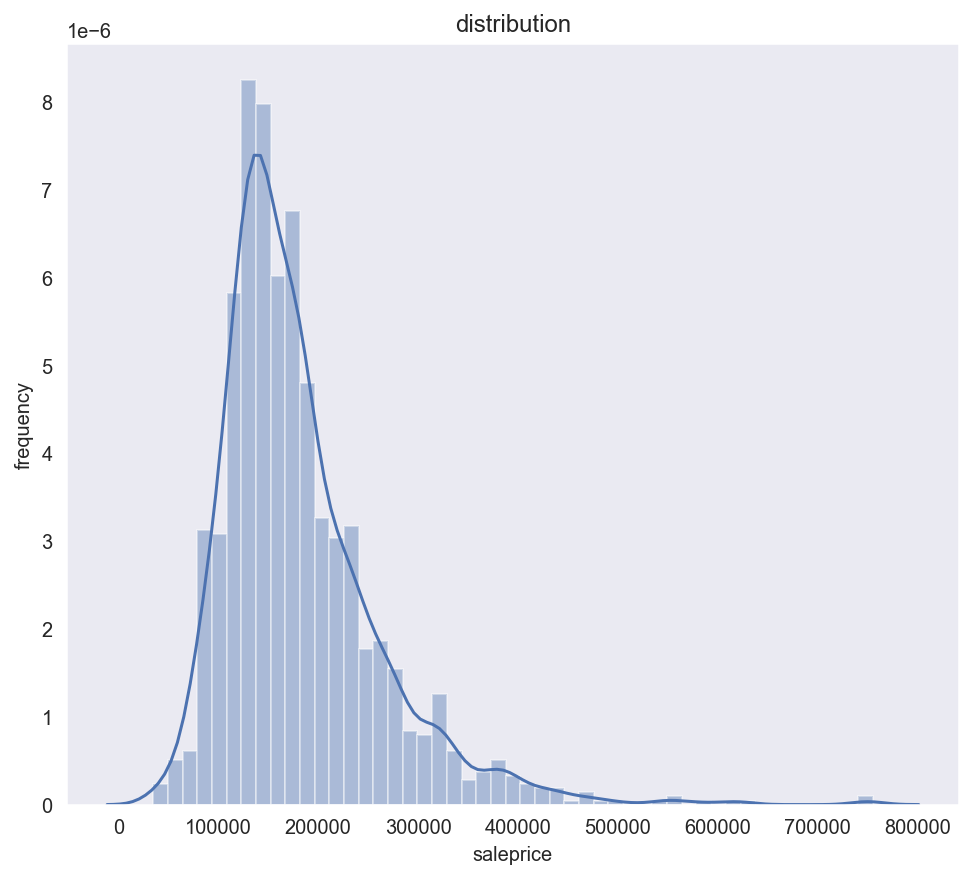

In [524]:
#Target will be Saleprice so lets take a look at its distribution
sns.set_style("dark")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7)) 
sns.distplot(house['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="frequency")
ax.set(xlabel="saleprice")
ax.set(title="distribution")
plt.show()

The mean for Sale Price is 180921.19589041095
The median for Sale Price is 163000.0


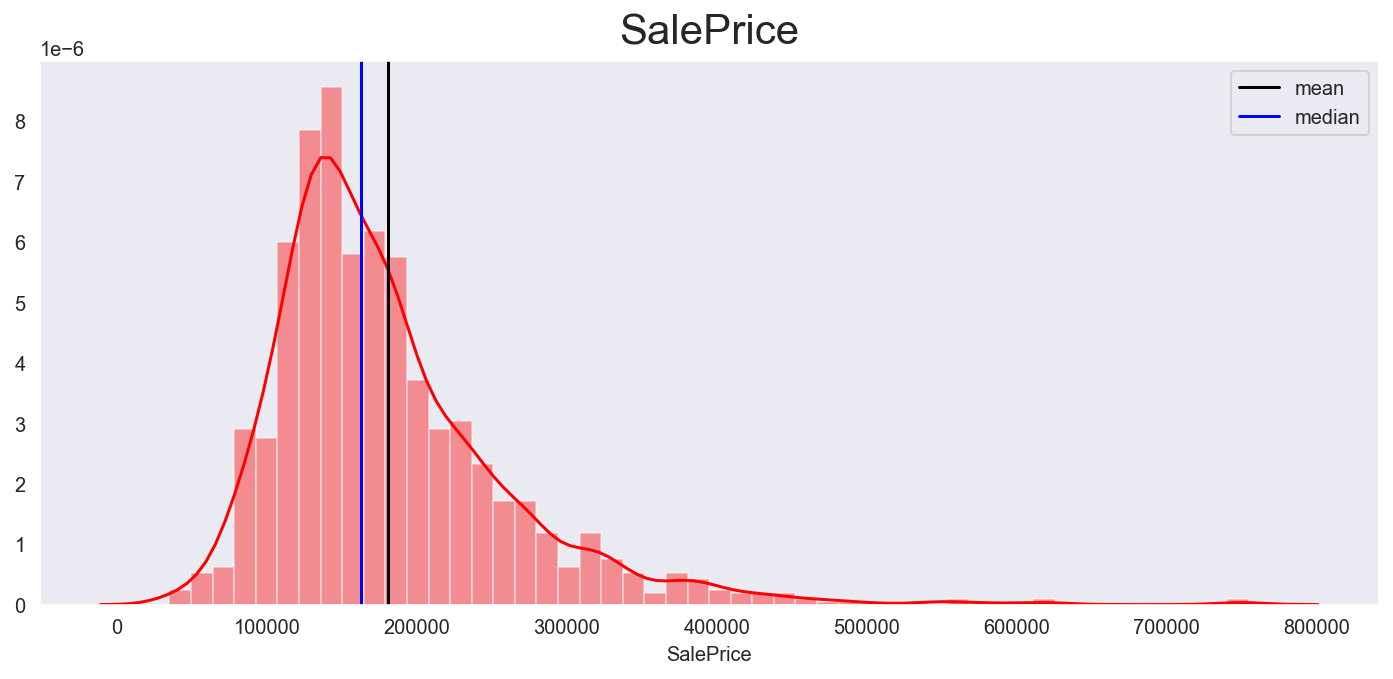

In [525]:
fig = plt.figure(figsize=(12,5))


ax = fig.gca()

ax.set_title('SalePrice', fontsize=21, y=1.01)

sns.distplot(house['SalePrice'], bins=50, color='red', ax=ax)

mean=ax.axvline(house['SalePrice'].mean(), color='black')
median=ax.axvline(house['SalePrice'].median(), color='blue')

plt.legend(['mean', 'median'])


print('The mean for Sale Price is', house['SalePrice'].mean())
print('The median for Sale Price is', house['SalePrice'].median())

In [526]:
# looking a bit more at Sales Price 

house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [528]:
print(str('Mean saleprice for Ames dataset: ' + str(house['SalePrice'].mean())))

Mean saleprice for Ames dataset: 180921.19589041095


In [530]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Dropping C (which stands for commercial) since we are looking for Residential

In [531]:
house = house[house.MSZoning != 'C (all)']

In [532]:
house.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [533]:
house.shape

(1450, 75)

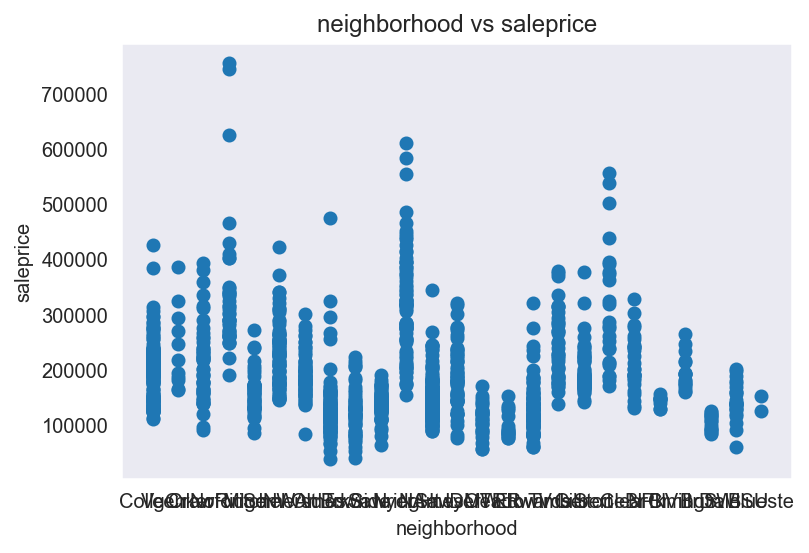

In [534]:
# Looking at neighborhood vs saleprice

plt.scatter(house.Neighborhood, house.SalePrice)

plt.title("neighborhood vs saleprice")
plt.xlabel("neighborhood")
plt.ylabel("saleprice")
plt.show()

# doesn't really show 

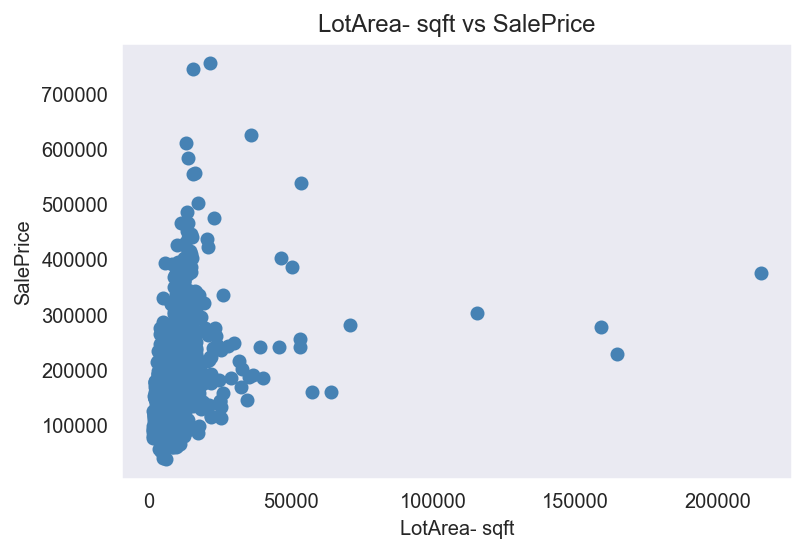

In [535]:
# Lot area sqr ft vs saleprice

plt.scatter(house.LotArea, house.SalePrice, c = "steelblue")

plt.title("LotArea- sqft vs SalePrice")
plt.xlabel("LotArea- sqft")
plt.ylabel("SalePrice")
plt.show()

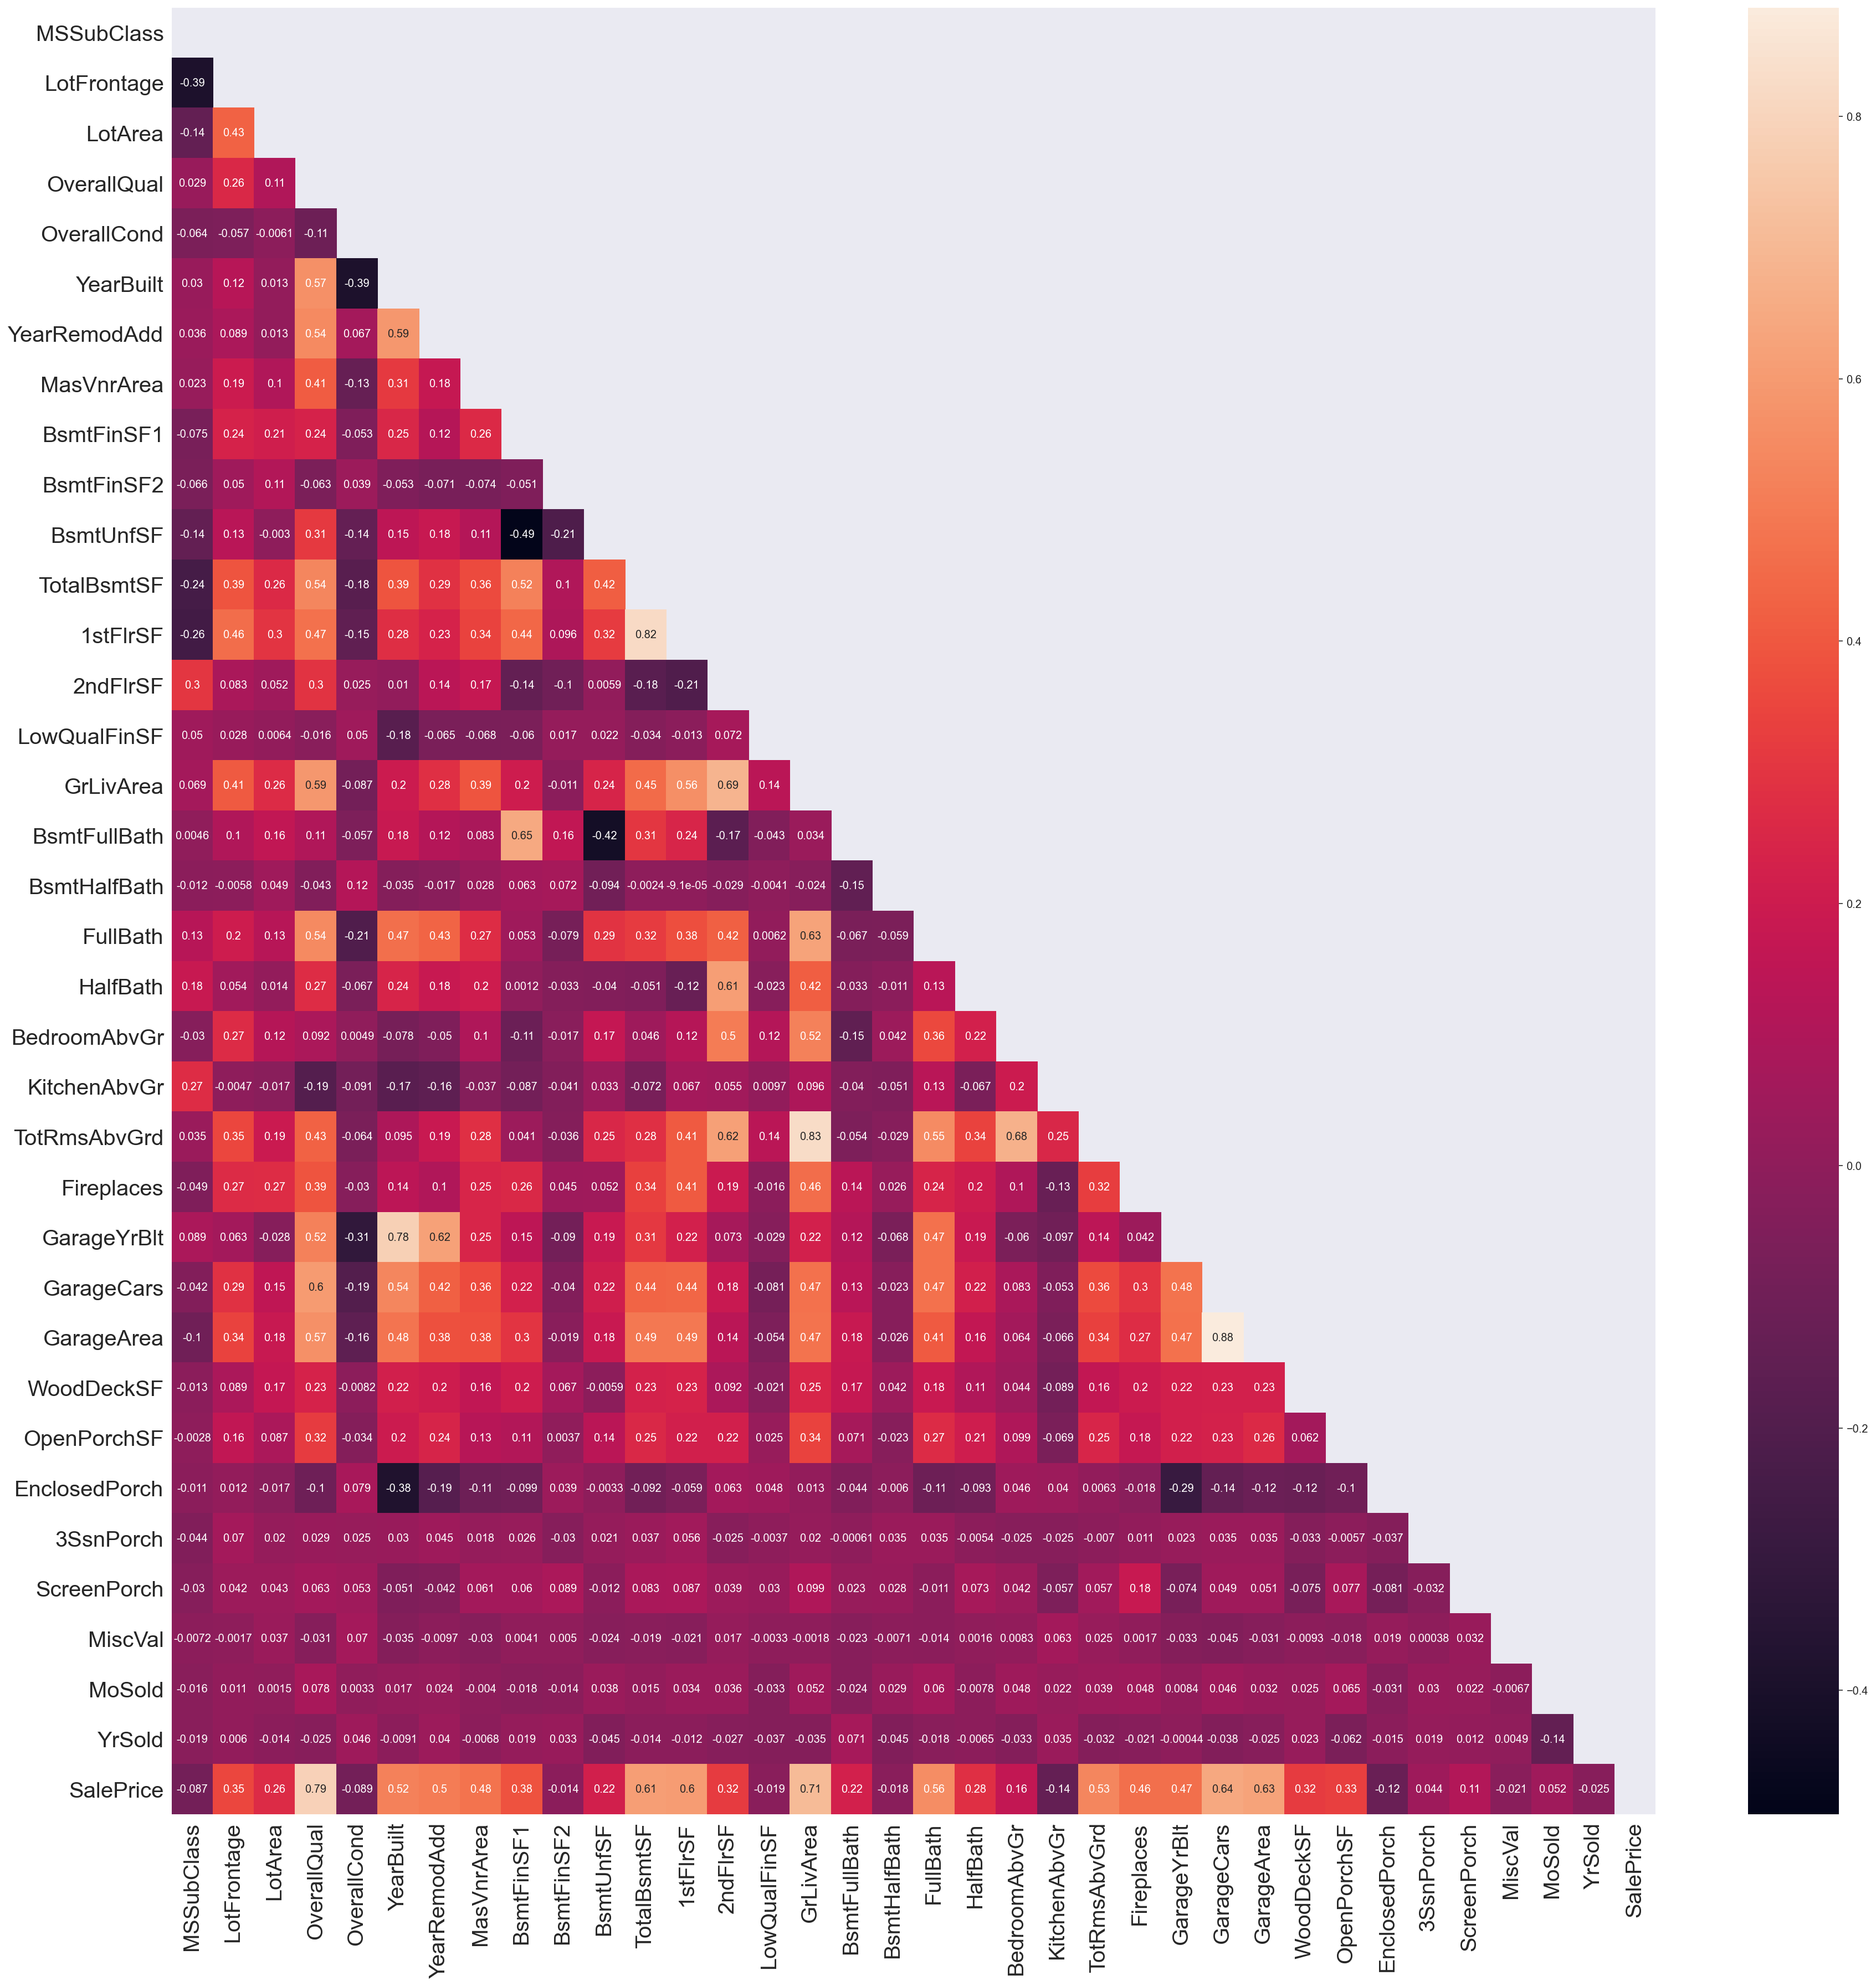

In [536]:
# Trying to look for some sort of collineararity 

fig, ax = plt.subplots(figsize=(30,30))

mask = np.zeros_like(house.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


ax = sns.heatmap(house.corr(), mask = mask, ax=ax,annot=True)


ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=20)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=20)

plt.show()


(-0.5, 9.5, 0.0, 800000.0)

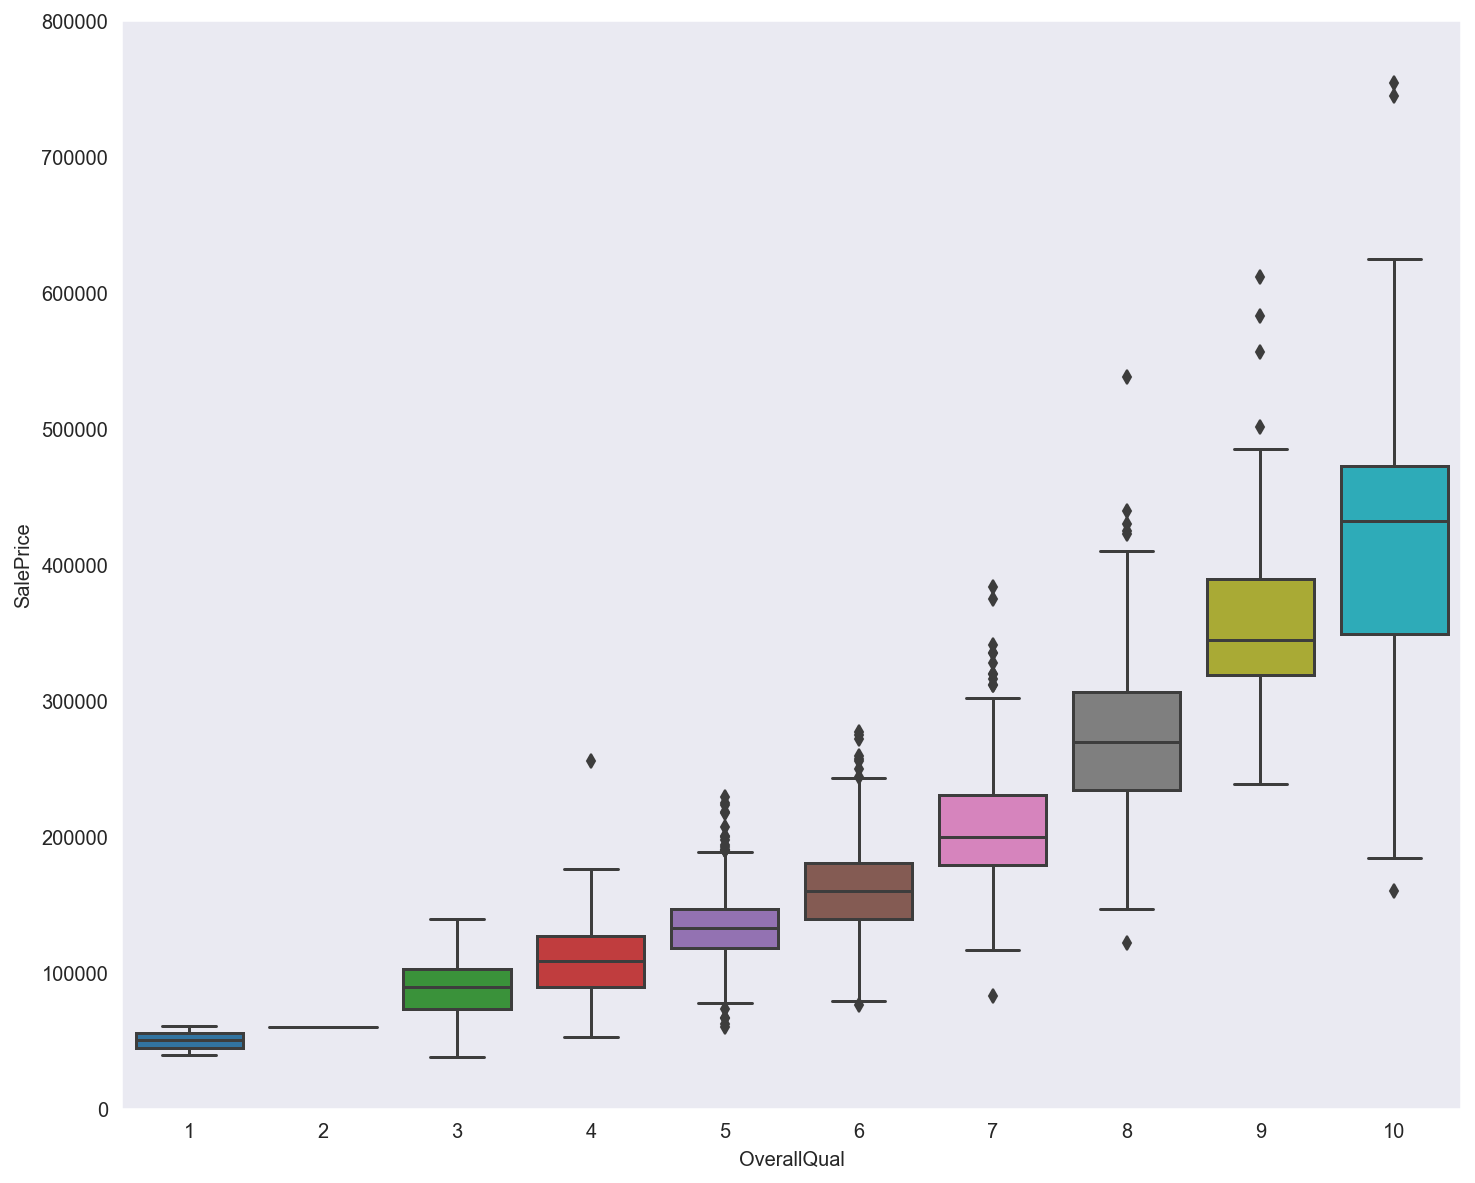

In [537]:
# can see high correlation between SalesPrice and OverallQual

data = pd.concat([house['SalePrice'], house['OverallQual']], axis = 1)
f, ax = plt.subplots(figsize = (12,10))
fig = sns.boxplot(x = house['OverallQual'], y = house['SalePrice'], data = data)
fig.axis(ymin = 0, ymax = 800000)

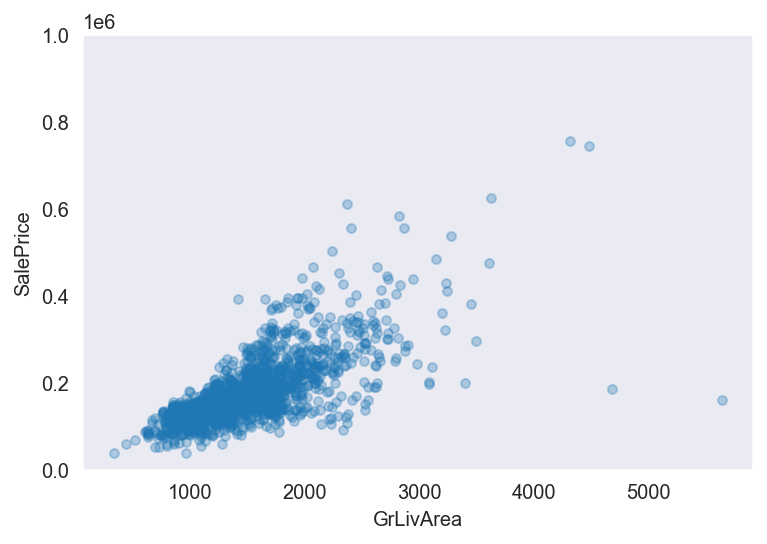

In [364]:
# Scatter plot to show the correlation for Gr Living Area

data = pd.concat([house['SalePrice'], house['GrLivArea']], axis = 1)
data.plot.scatter(x = 'GrLivArea', y = 'SalePrice', alpha = 0.3, ylim =(0, 1000000))

We can see outliers in the above graphs

In [538]:
# making an age of house category

house['Age'] = (house['YrSold'] - house['YearBuilt'])
house.head()

<ipython-input-538-c221b1226a6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house['Age'] = (house['YrSold'] - house['YearBuilt'])


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,2,2006,WD,Abnorml,140000,91
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,8


In [539]:
house.shape

(1450, 76)

In [540]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

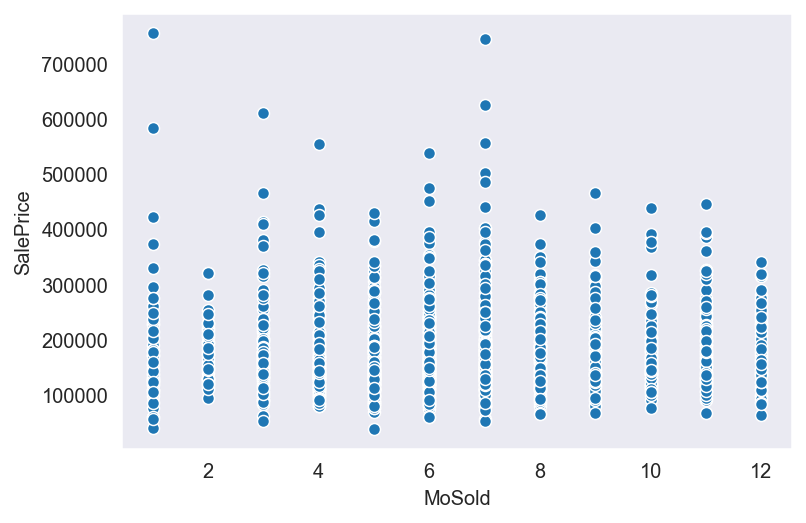

In [541]:
# Was told to take a look into seasons impacting sale trends, but can't really see any sort of month having higher sales
# than other months, so won't be taking this into account. 

sns.scatterplot(house['MoSold'],house['SalePrice']);



**Checking for Null Values**

In [542]:
house.isnull().sum().sort_values(ascending=False)

LotFrontage     259
MasVnrType        8
MasVnrArea        8
Electrical        1
Age               0
               ... 
KitchenQual       0
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
MSSubClass        0
Length: 76, dtype: int64

In [543]:
house.isnull().sum()

# should clean up LotFrontage - with either mean or 0 etc

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Age                0
Length: 76, dtype: int64

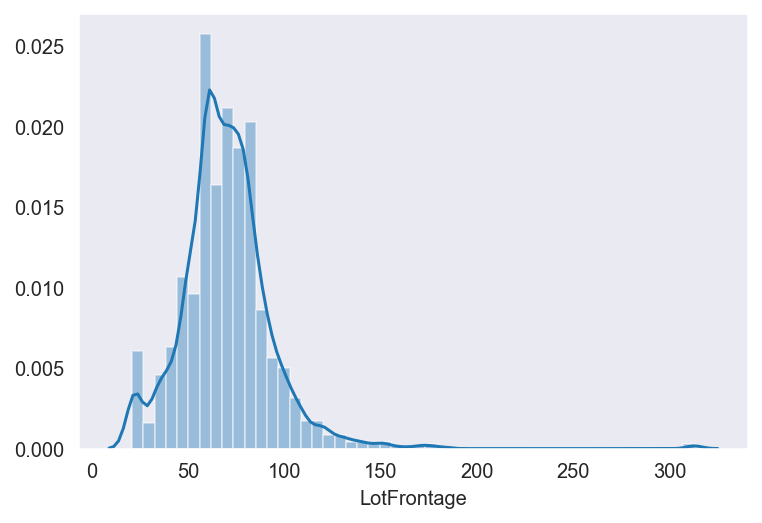

In [544]:
sns.distplot(house['LotFrontage'])

In [545]:
print(house['LotFrontage'].mean())
print(house['LotFrontage'].median())

# Mean is very similar to the median 

70.0528967254408
70.0


In [546]:
house.LotFrontage.fillna(0, inplace = True)

C:\Users\vgoun\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [547]:
house['LotFrontage'].isnull().sum()

0

In [548]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,2,2006,WD,Abnorml,140000,91
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,8


In [549]:
# Dealing with Null for Fire Place Quality
house.FireplaceQu.value_counts()

None    681
Gd      379
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64

In [550]:
# Replace Null with NA means no fire place
# fill fire place quality nan with NA
house.FireplaceQu.fillna('None', inplace=True)

C:\Users\vgoun\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [551]:
house['FireplaceQu'].unique()

array(['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [552]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1450 non-null   int64  
 1   MSZoning       1450 non-null   object 
 2   LotFrontage    1450 non-null   float64
 3   LotArea        1450 non-null   int64  
 4   Street         1450 non-null   object 
 5   LotShape       1450 non-null   object 
 6   LandContour    1450 non-null   object 
 7   Utilities      1450 non-null   object 
 8   LotConfig      1450 non-null   object 
 9   LandSlope      1450 non-null   object 
 10  Neighborhood   1450 non-null   object 
 11  Condition1     1450 non-null   object 
 12  Condition2     1450 non-null   object 
 13  BldgType       1450 non-null   object 
 14  HouseStyle     1450 non-null   object 
 15  OverallQual    1450 non-null   int64  
 16  OverallCond    1450 non-null   int64  
 17  YearBuilt      1450 non-null   int64  
 18  YearRemo

In [553]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

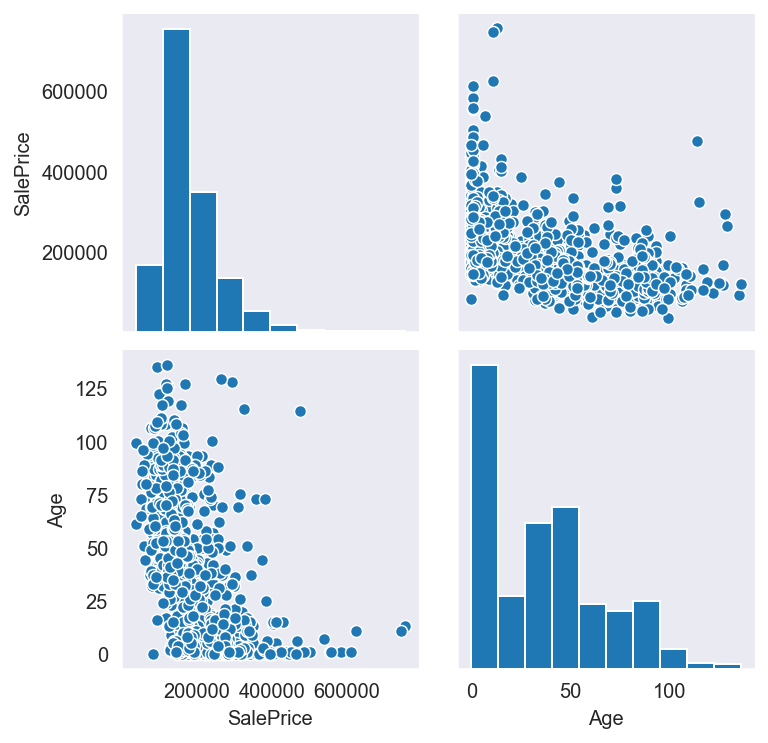

In [554]:
# plot Year columns against Sale Price
temp_df = house[['SalePrice','Age']]
sns.pairplot(temp_df)

In [ ]:
# Seems like the younger the house / property the higher the sale price - which makes sense. 
# However could be impacted by other factors as well such as area it's in, if the property is near any other structures
# of interest thus causing the property to inflate subsequently

Fixed Data with Features and Sale Price as target

In [555]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [556]:
non_reno = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'LotConfig', 
'LandSlope', 'Neighborhood','Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'MasVnrType',
'MasVnrArea', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Fireplaces', 'GarageType', 
'GarageFinish', 'GarageArea', 'MoSold', 'YrSold', 'Age', 'SalePrice']

In [557]:
# list of fixed column labels

non_reno = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'LotConfig', 
'LandSlope', 'Neighborhood','Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'MasVnrType', 
'MasVnrArea', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Fireplaces', 'GarageType', 
'GarageFinish', 'GarageArea', 'MoSold', 'YrSold', 'Age', 'SalePrice']

len(non_reno)


32

In [558]:
house.MasVnrType.fillna('None', inplace=True)
house.MasVnrArea.fillna('None', inplace=True)

In [559]:
non_reno

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'YearBuilt',
 'RoofStyle',
 'RoofMatl',
 'MasVnrType',
 'MasVnrArea',
 'Foundation',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Fireplaces',
 'GarageType',
 'GarageFinish',
 'GarageArea',
 'MoSold',
 'YrSold',
 'Age',
 'SalePrice']

In [560]:
# Get fixed feature from house data with Sale price
fixed_house = house[non_reno]

In [561]:
house

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,7
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,2,2006,WD,Abnorml,140000,91
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,8,2007,WD,Normal,175000,8
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2010,WD,Normal,210000,32
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,2500,5,2010,WD,Normal,266500,69
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,4,2010,WD,Normal,142125,60


In [562]:
fixed_house

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,BsmtUnfSF,TotalBsmtSF,Fireplaces,GarageType,GarageFinish,GarageArea,MoSold,YrSold,Age,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,...,150,856,0,Attchd,RFn,548,2,2008,5,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,...,284,1262,1,Attchd,RFn,460,5,2007,31,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,...,434,920,1,Attchd,RFn,608,9,2008,7,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,...,540,756,1,Detchd,Unf,642,2,2006,91,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,...,490,1145,1,Attchd,RFn,836,12,2008,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,Inside,Gtl,Gilbert,...,953,953,1,Attchd,RFn,460,8,2007,8,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,Inside,Gtl,NWAmes,...,589,1542,2,Attchd,Unf,500,2,2010,32,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,Inside,Gtl,Crawfor,...,877,1152,2,Attchd,RFn,252,5,2010,69,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,Inside,Gtl,NAmes,...,0,1078,0,Attchd,Unf,240,4,2010,60,142125


In [563]:
fixed_house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
       'RoofStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Fireplaces',
       'GarageType', 'GarageFinish', 'GarageArea', 'MoSold', 'YrSold', 'Age',
       'SalePrice'],
      dtype='object')

In [564]:
fixed_house.isna().sum()

MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
LotShape        0
LandContour     0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
YearBuilt       0
RoofStyle       0
RoofMatl        0
MasVnrType      0
MasVnrArea      0
Foundation      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
Fireplaces      0
GarageType      0
GarageFinish    0
GarageArea      0
MoSold          0
YrSold          0
Age             0
SalePrice       0
dtype: int64

In [565]:
house.shape

(1450, 76)

In [566]:
# Get X and Y Train

fixed_formula= '''
SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + LotShape + LandContour + LotConfig + LandSlope
+ Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + YearBuilt + RoofStyle + RoofMatl + MasVnrType
+ MasVnrArea + Foundation + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + Fireplaces + GarageType + GarageFinish
+ GarageArea + MoSold + YrSold + Age
'''

y, X = patsy.dmatrices(fixed_formula, data=fixed_house, return_type='dataframe', NA_action=patsy.NAAction(NA_types=[]))

In [567]:
y

,SalePrice
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0
...,...
1455,175000.0
1456,210000.0
1457,266500.0
1458,142125.0


In [568]:
X

,Intercept,MSZoning[T.RH],MSZoning[T.RL],MSZoning[T.RM],Street[T.Pave],LotShape[T.IR2],LotShape[T.IR3],LotShape[T.Reg],LandContour[T.HLS],LandContour[T.Low],...,YearBuilt,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Fireplaces,GarageArea,MoSold,YrSold,Age
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,2003.0,706.0,0.0,150.0,856.0,0.0,548.0,2.0,2008.0,5.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1976.0,978.0,0.0,284.0,1262.0,1.0,460.0,5.0,2007.0,31.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2001.0,486.0,0.0,434.0,920.0,1.0,608.0,9.0,2008.0,7.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1915.0,216.0,0.0,540.0,756.0,1.0,642.0,2.0,2006.0,91.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2000.0,655.0,0.0,490.0,1145.0,1.0,836.0,12.0,2008.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1999.0,0.0,0.0,953.0,953.0,1.0,460.0,8.0,2007.0,8.0
1456,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1978.0,790.0,163.0,589.0,1542.0,2.0,500.0,2.0,2010.0,32.0
1457,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1941.0,275.0,0.0,877.0,1152.0,2.0,252.0,5.0,2010.0,69.0
1458,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1950.0,49.0,1029.0,0.0,1078.0,0.0,240.0,4.0,2010.0,60.0


In [569]:
X.shape

(1450, 436)

In [571]:
# get the recent year indicies for testing

testing_year = house.YrSold == 2010

In [572]:
# Standardize X before splitting

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

In [573]:
X_train_1, X_test_1 = X[~testing_year], X[testing_year]

y_train_1, y_test_1 = y[~testing_year], y[testing_year]

In [574]:
X_train_1.shape 

(1278, 436)

In [575]:
X_test_1.shape

(172, 436)

In [576]:
y_train_1.shape

(1278, 1)

In [577]:
y_test_1.shape

(172, 1)

In [578]:
X_train_s_1 = ss.fit_transform(X_train_1)

X_test_s_1 = ss.transform(X_test_1)

In [579]:
X_train_s_1, X_test_s_1

(array([[ 0.        , -0.11259791,  0.51511798, ..., -1.68778009,
          0.42876315, -1.0213998 ],
        [ 0.        , -0.11259791,  0.51511798, ..., -0.58182404,
         -0.46078117, -0.16348593],
        [ 0.        , -0.11259791,  0.51511798, ...,  0.89278403,
          0.42876315, -0.95540643],
        ...,
        [ 0.        , -0.11259791, -1.94130284, ...,  1.26143605,
          1.31830747, -1.0213998 ],
        [ 0.        , -0.11259791,  0.51511798, ...,  0.52413202,
         -0.46078117, -0.92240974],
        [ 0.        , -0.11259791,  0.51511798, ..., -0.21317202,
          0.42876315,  0.23247431]]),
 array([[ 0.        , -0.11259791,  0.51511798, ..., -1.31912807,
          2.20785179,  0.13348425],
        [ 0.        , -0.11259791,  0.51511798, ..., -0.58182404,
          2.20785179,  0.19947763],
        [ 0.        , -0.11259791,  0.51511798, ..., -0.58182404,
          2.20785179,  0.76042131],
        ...,
        [ 0.        , -0.11259791,  0.51511798, ..., -

In [580]:
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score

In [581]:
lasso_cv_1 = LassoCV(n_alphas = 100, cv=10, verbose = 1)
lasso_cv_1.fit(X_train_s_1, y_train)

C:\Users\vgoun\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, verbose=1)

In [582]:
lasso_cv_1.score(X_test_s_1, y_test_1)

0.8259507472834746

In [583]:
lasso_cv_1.alpha_

1236.076201333437

In [584]:
lasso_best = Lasso(alpha = lasso_cv_1.alpha_)
lasso_best.fit(X_train_s, y_train)

Lasso(alpha=1236.076201333437)

In [585]:
lasso_best.score(X_test_s_1, y_test_1)

0.8259507472834746

In [586]:
lasso_cv_1.coef_

array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -8.59356817e+02,
        1.02865753e+03,  1.28766232e+03, -0.00000000e+00, -5.97003154e+02,
        1.02087447e+03, -0.00000000e+00, -0.00000000e+00,  1.48185212e+03,
       -2.26116249e+02, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -1.06577341e+03, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  4.47498295e+03, -3.95644091e+02,
       -6.14907031e+02, -0.00000000e+00, -4.96190540e+02, -1.88181436e+03,
       -1.83392320e+03, -0.00000000e+00, -0.00000000e+00,  8.12172086e+03,
        1.08093978e+04, -0.00000000e+00, -0.00000000e+00, -5.87417428e+02,
        0.00000000e+00,  3.63098910e+03,  6.60277542e+03,  0.00000000e+00,
        1.39061073e+03, -2.03003074e+02,  1.00345098e+03,  6.00647492e+02,
       -0.00000000e+00, -6.43518597e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.66770496e+03,
       -0.00000000e+00, -

In [587]:
fixed_house.shape

(1450, 32)

In [588]:
lasso_cv_1.coef_.shape

(436,)

In [589]:
lasso_features = pd.DataFrame(dict(feature = X.columns, coef = lasso_cv_1.coef_, absolutecoef=np.abs(lasso_cv.coef_)))

lasso_features.sort_values('absolutecoef', inplace=True, ascending=False)

lasso_features[lasso_features.coef != 0.]

,feature,coef,absolutecoef
430,TotalBsmtSF,26019.208679,26019.208679
393,MasVnrArea[T.796.0],-15182.635851,15182.635851
432,GarageArea,13353.447824,13353.447824
32,Neighborhood[T.NridgHt],10809.397796,10809.397796
61,HouseStyle[T.1Story],-10805.863844,10805.863844
...,...,...,...
171,MasVnrArea[T.145.0],75.419852,75.419852
248,MasVnrArea[T.255.0],-49.919647,49.919647
77,RoofMatl[T.WdShake],46.555324,46.555324
132,MasVnrArea[T.94.0],-21.666501,21.666501


In [592]:
lasso_features

,feature,coef,absolutecoef
430,TotalBsmtSF,26019.208679,26019.208679
393,MasVnrArea[T.796.0],-15182.635851,15182.635851
432,GarageArea,13353.447824,13353.447824
32,Neighborhood[T.NridgHt],10809.397796,10809.397796
61,HouseStyle[T.1Story],-10805.863844,10805.863844
...,...,...,...
178,MasVnrArea[T.153.0],0.000000,0.000000
177,MasVnrArea[T.151.0],0.000000,0.000000
176,MasVnrArea[T.150.0],-0.000000,0.000000
175,MasVnrArea[T.149.0],-0.000000,0.000000


In [594]:
import statsmodels

from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF =  [statsmodels.stats.outliers_influence.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]              
# print("Multicollinearity check: VIF scores", VIF)

C:\Users\vgoun\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\vgoun\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [593]:
lasso_features['VIF'] = VIF

In [596]:
lasso_features.head(30)

,feature,coef,absolutecoef,VIF
430,TotalBsmtSF,26019.208679,26019.208679,0.000000
393,MasVnrArea[T.796.0],-15182.635851,15182.635851,3.787500
432,GarageArea,13353.447824,13353.447824,36.916482
32,Neighborhood[T.NridgHt],10809.397796,10809.397796,34.479786
61,HouseStyle[T.1Story],-10805.863844,10805.863844,1.783832
431,Fireplaces,9192.673780,9192.673780,1.546809
435,Age,-8375.098981,8375.098981,1.401848
31,Neighborhood[T.NoRidge],8121.720856,8121.720856,2.179406
64,HouseStyle[T.2Story],7799.427154,7799.427154,2.700959
427,BsmtFinSF1,7509.395615,7509.395615,2.765843


# Few notes to say regarding the VIF:

Te vif score is defined as ( 1 / 1 - R2). This R2 is from every feature run against everything else and regressed against them. 
e.g. total basement sq ft - taking it as y and everything else is the predictor matrix against that. 

it makes the feature on the LHS as the target. and tries to explain the variance and makes them all independant of each other. 

This is how we measure Multi collinearity - by running 1 against the rest. Thus the higher the VIF the higher the MC.

looking at - fixed feautres only, total basmtn 1 sd increase of 26k - low vif (isn't suffering MC)
garage area 1sd increase - 13k increase HOWEVER huge MC


In [460]:
pd.Series(VIF).describe()

# mean = infinity - due to very high VIF (R2 practically divded by 1) 
# median = 1.64 

count    436.000000
mean            inf
std             NaN
min        0.000000
25%        1.365470
50%        1.643455
75%        2.304698
max             inf
dtype: float64

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:


# Fall Back Plan #  

Combined both fixed and renovatable features into 1 and ran a new Lasso Regression model on that instead.

In [146]:
# adding both fixed and reno predictors together and running that onto a new lasso LR model

In [241]:
combined_formula = '''
SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + LotShape + LandContour + LotConfig + LandSlope
+ Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + YearBuilt + RoofStyle + RoofMatl + MasVnrType
+ MasVnrArea + Foundation + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + Fireplaces + GarageType + GarageFinish
+ GarageArea + MoSold + YrSold + Age + Utilities + OverallQual + OverallCond + YearRemodAdd + Exterior1st + Exterior2nd + ExterQual + ExterCond + 
BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinType2 + Heating + HeatingQC + CentralAir + Electrical
+ LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + 
KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Functional + FireplaceQu + GarageYrBlt + GarageCars + GarageQual + GarageCond
+ PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + ScreenPorch + MiscVal + SaleType + SaleCondition
'''



In [415]:
y_2, X_2 = patsy.dmatrices(combined_formula, data=house, return_type='dataframe', NA_action=patsy.NAAction(NA_types=[]))

In [416]:
X_2

,Intercept,MSZoning[T.RH],MSZoning[T.RL],MSZoning[T.RM],Street[T.Pave],LotShape[T.IR2],LotShape[T.IR3],LotShape[T.Reg],LandContour[T.HLS],LandContour[T.Low],...,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,8.0,2003.0,2.0,0.0,61.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,6.0,1976.0,2.0,298.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,6.0,2001.0,2.0,0.0,42.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,7.0,1998.0,3.0,0.0,35.0,272.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,9.0,2000.0,3.0,192.0,84.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,7.0,1999.0,2.0,0.0,40.0,0.0,0.0,0.0
1456,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,7.0,1978.0,2.0,349.0,0.0,0.0,0.0,0.0
1457,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4.0,1.0,9.0,1941.0,1.0,0.0,60.0,0.0,0.0,2500.0
1458,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,2.0,1.0,5.0,1950.0,1.0,366.0,0.0,112.0,0.0,0.0


In [425]:
lasso_cv_2.coef_.shape

(570,)

In [417]:
testing_year = house.YrSold == 2010

X_train_2, X_test_2 = X_2[~testing_year], X_2[testing_year]

y_train_2, y_test_2 = y_2[~testing_year], y_2[testing_year]


In [419]:
X_train_2_ss = ss.fit_transform(X_train_2)

X_test_2_ss = ss.transform(X_test_2)

lasso_cv_2 = LassoCV(n_alphas = 100, cv=10, verbose = 1)
lasso_cv_2.fit(X_train_2_ss, y_train_2)

print(lasso_cv_2.alpha_)

C:\Users\vgoun\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

669.9472972398192


In [420]:
lasso_cv_2 = Lasso(alpha = lasso_cv_2.alpha_)

lasso_cv_2.fit(X_train_2_ss, y_train_2)

print(lasso_cv_2.score(X_test_2_ss, y_test_2))

0.8913110769945862


In [447]:
VIF_2 = [statsmodels.stats.outliers_influence.variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]    

In [438]:
lasso_features_2 = pd.DataFrame(dict(feature = X_2.columns, coef = lasso_cv_2.coef_, absolutecoef=np.abs(lasso_cv_2.coef_)))

lasso_features_2.sort_values('absolutecoef', inplace=True, ascending=False)

lasso_features_2[lasso_features_2.coef != 0.]

lasso_features_2['VIF_2'] = VIF_2

,feature,coef,absolutecoef
555,GrLivArea,30217.826396,30217.826396
393,MasVnrArea[T.796.0],-15066.602477,15066.602477
551,OverallQual,14328.950537,14328.950537
388,MasVnrArea[T.762.0],-9893.137312,9893.137312
542,BsmtFinSF1,7675.582430,7675.582430
...,...,...,...
502,Functional[T.Maj2],-20.503704,20.503704
208,MasVnrArea[T.194.0],18.490754,18.490754
499,KitchenQual[T.Fa],-13.449778,13.449778
138,MasVnrArea[T.100.0],1.930271,1.930271


In [490]:
lasso_features_2.head(20)

,feature,coef,absolutecoef,VIF
555,GrLivArea,30217.826396,30217.826396,0.000000
393,MasVnrArea[T.796.0],-15066.602477,15066.602477,4.191494
551,OverallQual,14328.950537,14328.950537,40.178656
388,MasVnrArea[T.762.0],-9893.137312,9893.137312,38.081170
542,BsmtFinSF1,7675.582430,7675.582430,2.075347
32,Neighborhood[T.NridgHt],6674.431027,6674.431027,1.774382
461,BsmtQual[T.Gd],-6640.501141,6640.501141,1.627442
545,TotalBsmtSF,6447.964512,6447.964512,2.444235
31,Neighborhood[T.NoRidge],5259.209191,5259.209191,3.188868
530,SaleType[T.New],5201.018015,5201.018015,3.381715


In [487]:
lasso_features_2['VIF'] = VIF_2

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: